# Get multibolid data



In [2]:
from MLABvo.Bolidozor import Bolidozor
import json
import datetime
import numpy as np
import scipy.signal
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import dates
import mpltools
import sys
sys.path.append("..") 
import recviewer
import dateutil.parser

%matplotlib inline 

# Inicializace bolidozoru

Funkce ```Bolidozor.getMultibolid``` jako jediný parametr bere id skupiny, které lze zjistit například zde: http://rtbolidozor.astro.cz/multibolid/

In [3]:
multibolid_id = 1440053

In [4]:
bz = Bolidozor()
bolids = bz.getMultibolid(id=multibolid_id)
print('Počet detekcí ve skupině je',len(bolids.result))

Počet detekcí ve skupině je 7


Získaná data z MLABvo jsou k dispozici v ```Bolidozor.getMultibolid.result```.

Následující buňka ukazuje, jak lze procházet záznamy po jednom.

**Výsledek obsahuje následující informace**

In [5]:
print(list(bolids.result[0].keys()))
print("")
print(bolids.result[0])

['url_file', 'peak_f', 'url_station', 'filepath', 'noise', 'magnitude', 'filename_raw', 'station_name', 'id_server', 'filename', 'event_id', 'url_file_js9', 'observatory_name', 'namesimple', 'duration', 'file_status', 'obstime', 'observatory_namesimple', 'url_file_raw', 'id_observer']

{'url_file': 'http://space.astro.cz/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/20/15/20170920153247610_VALMEZ-R1_met.fits', 'peak_f': 26541.5, 'url_station': 'http://api.vo.astro.cz/bolidozor/getStation/?id=30', 'filepath': '/storage/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/20/15', 'noise': 7.5954, 'magnitude': 25.9652, 'filename_raw': '20170920153247610_VALMEZ-R1_raws.fits', 'station_name': 'VALMEZ-R1', 'id_server': 1, 'filename': '20170920153247610_VALMEZ-R1_met.fits', 'event_id': 932373, 'url_file_js9': 'http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/20/15/20170920153247610_VALMEZ-R1_met.fits', 'observatory_name': 'valmez', 'namesimple': 'VALMEZ-R1', 

Nahrát data do cache

In [6]:
for i, bolid in enumerate(bolids.result):
    print(i+1,'z',len(bolids.result))
    fits.open(bolid['url_file_raw'])

1 z 7
2 z 7
3 z 7
4 z 7
5 z 7
6 z 7
7 z 7


# Kalibrace času

tato funkce projde RAW soubory a snaží se v nich vyhledat GPS značku. 

Výstupem této funkce je ```dictionary```, který obsahuje informace o času na začátku souboru, času konce souboru a prvního vzorku s GPS značkou ze systémového času stanice. Tyto samé časy vrací taktéž oproti GPS času.


In [7]:
def getMeteorAround(station, time, distance = datetime.timedelta(minutes=600)):
    try:
        b = Bolidozor(debug = False)
        print(station, b.setStation(station))

        meteors = b.getMeteor(date_from=time-distance, date_to=time+distance, min_duration=1).result
        #if len(meteors) > 0:
            #for met in meteors:
            #    print(met['url_file_raw'], met['duration'], met['obstime'])
    
        return meteors
    except Exception as e:
        print('getMeteorAround', e)
        return False

Tato smyčka projde všechny soubory a použije na nich funkci pro kalibraci času. Výstup přidá do původní proměnné pod klíčem ```time_calib```.

Pokud je zapnuté debugování, tak ze skriptu vypadávají tato data:

delka zaznamu          : Délka záznamu
cas prvni vzorku s GPS : 
cas 1. GPS a konec     : Vzdálenost první detekované GPS ke konci souboru
SysCas ukladani souboru: Čas z hlavičky FITSu ['DATE']
SysCas zacatku souboru : Čas z hlavičky ['DATE'] mínus délka souboru
SysCas 1. GPS znacky   : Systémový čas stanice v okamžiku GPS značky
Korekce systémoveho čas: Systémový čas 
CorCas ukladani souboru: 2017-09-23 07:24:19.241618 s
CorCas zacatku souboru : 2017-09-23 07:24:06.241614
CorCas 1. GPS znacky   : 2017-09-23 07:24:10

In [8]:
np.set_printoptions(suppress=True)

def samp2time(sample):
    return sample/2*1/96000
def time2samp(time):
    return time*2*96000
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='full')
    return y_smooth

def timeCalibration(raw_file, station=None, sigma = 15, debug = True, browse_around = True):
    calibration_data = {}
    calibration_data['samp_correction'] = 0
    # Stahnout a otevrit RAW fits meteoru
    hdulist = fits.open(raw_file, cache=True)
    met_data = np.abs(np.ravel(hdulist[0].data))
    met_smooth = smooth(met_data, 25)
    clip_val = np.std(met_data)*sigma
    
    #file_length = hdulist[0].header['NAXIS2']*hdulist[0].header['CDELT2']/1000.0
    file_length = samp2time(hdulist[0].header['NAXIS2']*2)
    DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
    DATE = datetime.datetime.strptime(hdulist[0].header['DATE'], "%Y-%m-%dT%H:%M:%S" )
    calibration_data['sys_file_beg'] = DATE-datetime.timedelta(seconds=file_length)
    calibration_data['sys_file_end'] = DATE
    
    if debug: plt.axhline(y=clip_val, color='red')
    max_val = np.max(met_data)
    time_firstGPS = None
    ten_sec = []
        
    # Tato cast hleda v datech GPS znacky
    # Kdyz je najde, zapise je do seznamu `ten_sec`
    # Prvni GPS znacku to ulozi jako float do `time_firstGPS`
    
    for i, point in enumerate(met_smooth):
        if point > clip_val:
            if not time_firstGPS:
                 time_firstGPS = samp2time(i)
                 if debug: 
                    plt.axvline(x=time2samp(time_firstGPS), color='red', lw=2)
                    plt.axvline(x=time2samp(time_firstGPS)+time2samp(10), color='green', lw=2)
            ten_sec.append(samp2time(i))
    
    # Ohodnotit kvalitu dat,
        #  100 - Velmi dobre - jasna GPS znacka,
        #  50  - Znacka není - najdeme ji v jiném souboru a zarovnáme podle vzorků zvukovky
        #  0  - Data jsou nekvalitni, nelze je pouzivat
    
    if time_firstGPS:
        calibration_data['quality'] = 100
        calibration_data['method'] = 'GPS'
        gps = (DATE-datetime.timedelta(seconds=file_length-time_firstGPS)).timestamp()
        correction = seconds=round(gps/10.0)*10-gps
    elif clip_val > 0.9:
        calibration_data['quality'] = 0
        calibration_data['method'] = 'Null'
        correction = 0
    else:
        calibration_data['quality'] = 50
        calibration_data['method'] = 'Around GPS'
        correction = 0
        
        # Kdyz je kvalita 50 (znacka neni v rozsahu zaznamu),
        #  tak se pokusi sehnat seznam okolnich meteoru,
        #  ve kterych najde GPS znacky
    
        if browse_around and station:
            time_offset = []
            if debug: print("hledam alternativni zdroj presneho casu")
            around = getMeteorAround(station, datetime.datetime.strptime(hdulist[0].header['DATE'], "%Y-%m-%dT%H:%M:%S" ))
            if around:
                print("Okolnich souboru:", len(around))
                for meteor in around:
                    meteor_data = timeCalibration(meteor['url_file_raw'], debug=False, browse_around = False)
                    if meteor_data['quality'] == 100:

                        time_offset.append([
                            meteor_data['CRVAL2'],
                            meteor_data['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp(),
                            meteor_data['samp_correction'],
                            #meteor_data['CRVAL2']-meteor_data['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()
                                            ])
                        print("+", end='')
                    else:
                        print("-", end='')
                        
                ## plt.plot(time_offset)
                #plt.show()
                #for ar in time_offset:
                #    print("%f %f %f" %(ar[0], ar[1], ar[2]))
                mean = np.mean(np.array(time_offset)[:,2])
                print("mean: %f, std: %f" %(mean, np.std(np.array(time_offset)[:,2])))
                calibration_data['samp_correction'] = mean
            else:
                print("## Nelze najit žádné daší meteory v okolí")
                calibration_data['method'] = 'Null'
                calibration_data['quality'] = 25
            
                    
    if not time_firstGPS: time_firstGPS = 0
    correction = datetime.timedelta(seconds=correction)
    
    
    calibration_data['CRVAL2'] = hdulist[0].header['CRVAL2']/1000.0
    calibration_data['DATE-OBS'] = DATE_OBS
    
    calibration_data['sys_1st_GPS'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)
    calibration_data['sys_error'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)
    
    calibration_data['cor_file_beg'] = DATE-datetime.timedelta(seconds=file_length)+correction
    calibration_data['cor_file_end'] = DATE+correction
    calibration_data['cor_1st_GPS'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)+correction
    
    calibration_data['sys_correction'] = correction
    if calibration_data['samp_correction'] == 0:
        calibration_data['samp_correction'] = calibration_data['CRVAL2']-calibration_data['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()
    else:
        calibration_data['cor_file_beg'] = datetime.datetime.utcfromtimestamp(calibration_data['CRVAL2'])-datetime.timedelta(seconds=calibration_data['samp_correction'])
        calibration_data['cor_file_end'] = datetime.datetime.utcfromtimestamp(calibration_data['CRVAL2'])-datetime.timedelta(seconds=calibration_data['samp_correction']-file_length)
        calibration_data['cor_1st_GPS'] = datetime.datetime.utcfromtimestamp(calibration_data['CRVAL2'])-datetime.timedelta(seconds=calibration_data['samp_correction'])
    
    if debug:
        #DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
        print("Zpracovavam soubor:", raw_file)
        print('delka zaznamu          :', file_length, "s")
        print('cas prvni. vzorku s GPS:', time_firstGPS, "s")
        print('cas 1. GPS a konec     :', file_length - time_firstGPS, "s")
        print('SysCas ukladani souboru:', calibration_data['sys_file_end'], "s")
        print('SysCas zacatku souboru :', calibration_data['sys_file_beg'])
        print('SysCas 1. GPS znacky   :', calibration_data['sys_1st_GPS'])
        print('Korekce systémoveho čas:', calibration_data['sys_correction'])
        print('Korekce času zvukovky  :', calibration_data['samp_correction'])
        print('CorCas ukladani souboru:', calibration_data['cor_file_end'], "s")
        print('CorCas zacatku souboru :', calibration_data['cor_file_beg'])
        print('CorCas 1. GPS znacky   :', calibration_data['cor_1st_GPS'])
        print('Kvalita souboru        :', calibration_data['quality'])
        print('Počet vzorků s gps znač:', len(ten_sec))
        plt.plot(met_data, lw=0.5)
        plt.plot(met_smooth)
        plt.show()
    return calibration_data
        

0 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/20/15/20170920153247610_VALMEZ-R1_met.fits
hledam alternativni zdroj presneho casu
VALMEZ-R1 True
Okolnich souboru: 47
--++++++--+-+++-+++----++-++-++++++++++++++-++-mean: 16.065438, std: 0.654466
Zpracovavam soubor: http://space.astro.cz/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/20/15/20170920153247610_VALMEZ-R1_raws.fits
delka zaznamu          : 8.199989583333334 s
cas prvni. vzorku s GPS: 0 s
cas 1. GPS a konec     : 8.199989583333334 s
SysCas ukladani souboru: 2017-09-20 15:32:38 s
SysCas zacatku souboru : 2017-09-20 15:32:29.800010
SysCas 1. GPS znacky   : 2017-09-20 15:32:29.800010
Korekce systémoveho čas: 0:00:00
Korekce času zvukovky  : 16.065438155
CorCas ukladani souboru: 2017-09-20 15:32:39.744551 s
CorCas zacatku souboru : 2017-09-20 15:32:31.544562
CorCas 1. GPS znacky   : 2017-09-20 15:32:31.544562
Kvalita souboru        : 50
Poče

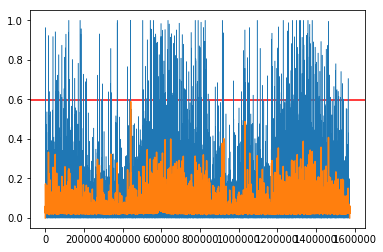

1 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/nachodsko/NACHODSKO-R5/meteors/2017/09/20/15/20170920153248171_NACHODSKO-R5_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/nachodsko/NACHODSKO-R5/meteors/2017/09/20/15/20170920153248171_NACHODSKO-R5_raws.fits
delka zaznamu          : 6.4 s
cas prvni. vzorku s GPS: 0 s
cas 1. GPS a konec     : 6.4 s
SysCas ukladani souboru: 2017-09-20 15:32:39 s
SysCas zacatku souboru : 2017-09-20 15:32:32.600000
SysCas 1. GPS znacky   : 2017-09-20 15:32:32.600000
Korekce systémoveho čas: 0:00:00
Korekce času zvukovky  : 15.571000099182129
CorCas ukladani souboru: 2017-09-20 15:32:39 s
CorCas zacatku souboru : 2017-09-20 15:32:32.600000
CorCas 1. GPS znacky   : 2017-09-20 15:32:32.600000
Kvalita souboru        : 0
Počet vzorků s gps znač: 0


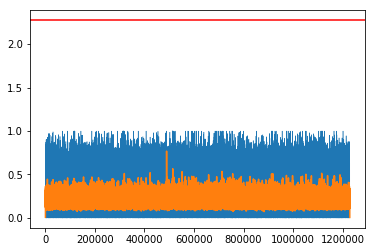

2 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/OBSUPICE/OBSUPICE-R6/meteors/2017/09/20/15/20170920153216699_OBSUPICE-R6_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/OBSUPICE/OBSUPICE-R6/meteors/2017/09/20/15/20170920153216699_OBSUPICE-R6_raws.fits
delka zaznamu          : 7.0 s
cas prvni. vzorku s GPS: 0 s
cas 1. GPS a konec     : 7.0 s
SysCas ukladani souboru: 2017-09-20 15:32:39 s
SysCas zacatku souboru : 2017-09-20 15:32:32
SysCas 1. GPS znacky   : 2017-09-20 15:32:32
Korekce systémoveho čas: 0:00:00
Korekce času zvukovky  : -15.301000118255615
CorCas ukladani souboru: 2017-09-20 15:32:39 s
CorCas zacatku souboru : 2017-09-20 15:32:32
CorCas 1. GPS znacky   : 2017-09-20 15:32:32
Kvalita souboru        : 0
Počet vzorků s gps znač: 0


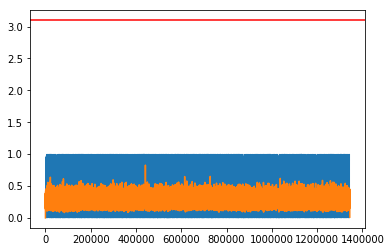

3 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/09/20/15/20170920153247454_DDMTREBIC-R3_met.fits
hledam alternativni zdroj presneho casu
DDMTREBIC-R3 True
Okolnich souboru: 137
-+----+----++--------+--+--+++--++------+-+--+++-+-+-+-+++-----+---+-+------+-------+----+------+-----+--+----++---+-+-------+---++-++-+-mean: 13.920945, std: 0.808326
Zpracovavam soubor: http://space.astro.cz/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/09/20/15/20170920153247454_DDMTREBIC-R3_raws.fits
delka zaznamu          : 5.8 s
cas prvni. vzorku s GPS: 0 s
cas 1. GPS a konec     : 5.8 s
SysCas ukladani souboru: 2017-09-20 15:32:39 s
SysCas zacatku souboru : 2017-09-20 15:32:33.200000
SysCas 1. GPS znacky   : 2017-09-20 15:32:33.200000
Korekce systémoveho čas: 0:00:00
Korekce času zvukovky  : 13.920945499
CorCas ukladani souboru: 2017-09-20 15:32:39.333055 s
CorCas zacatku souboru : 2017-09-20 15:32:33.533055


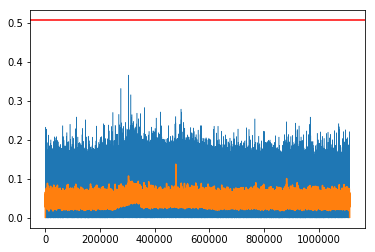

4 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/HFN/HFN-R1/meteors/2017/09/20/15/20170920153234241_HFN-R1_met.fits
hledam alternativni zdroj presneho casu
getMeteorAround list index out of range
## Nelze najit žádné daší meteory v okolí
Zpracovavam soubor: http://space.astro.cz/bolidozor/HFN/HFN-R1/meteors/2017/09/20/15/20170920153234241_HFN-R1_raws.fits
delka zaznamu          : 6.0 s
cas prvni. vzorku s GPS: 0 s
cas 1. GPS a konec     : 6.0 s
SysCas ukladani souboru: 2017-09-20 15:32:40 s
SysCas zacatku souboru : 2017-09-20 15:32:34
SysCas 1. GPS znacky   : 2017-09-20 15:32:34
Korekce systémoveho čas: 0:00:00
Korekce času zvukovky  : 0.24099993705749512
CorCas ukladani souboru: 2017-09-20 15:32:40 s
CorCas zacatku souboru : 2017-09-20 15:32:34
CorCas 1. GPS znacky   : 2017-09-20 15:32:34
Kvalita souboru        : 25
Počet vzorků s gps znač: 0


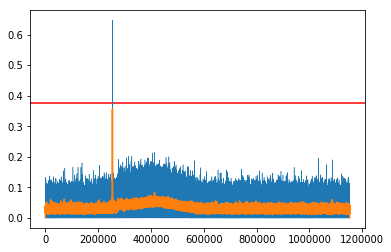

5 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/20/15/20170920153218631_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/20/15/20170920153218631_SVAKOV-R12_raws.fits
delka zaznamu          : 12.8 s
cas prvni. vzorku s GPS: 1.177921875 s
cas 1. GPS a konec     : 11.622078125000002 s
SysCas ukladani souboru: 2017-09-20 15:32:40 s
SysCas zacatku souboru : 2017-09-20 15:32:27.200000
SysCas 1. GPS znacky   : 2017-09-20 15:32:28.377922
Korekce systémoveho čas: 0:00:01.622078
Korekce času zvukovky  : -10.191077947616577
CorCas ukladani souboru: 2017-09-20 15:32:41.622078 s
CorCas zacatku souboru : 2017-09-20 15:32:28.822078
CorCas 1. GPS znacky   : 2017-09-20 15:32:30
Kvalita souboru        : 100
Počet vzorků s gps znač: 3344


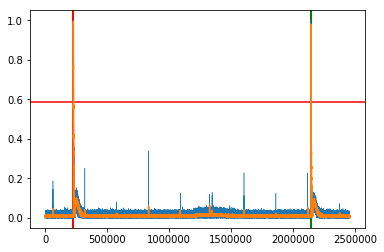

6 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/CIIRC/CIIRC-R1/meteors/2017/09/20/15/20170920153251991_CIIRC-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/CIIRC/CIIRC-R1/meteors/2017/09/20/15/20170920153251991_CIIRC-R1_raws.fits
delka zaznamu          : 6.8 s
cas prvni. vzorku s GPS: 6.130333333333334 s
cas 1. GPS a konec     : 0.6696666666666662 s
SysCas ukladani souboru: 2017-09-20 15:32:40 s
SysCas zacatku souboru : 2017-09-20 15:32:33.200000
SysCas 1. GPS znacky   : 2017-09-20 15:32:39.330333
Korekce systémoveho čas: 0:00:00.669667
Korekce času zvukovky  : 18.12133288383484
CorCas ukladani souboru: 2017-09-20 15:32:40.669667 s
CorCas zacatku souboru : 2017-09-20 15:32:33.869667
CorCas 1. GPS znacky   : 2017-09-20 15:32:40
Kvalita souboru        : 100
Počet vzorků s gps znač: 1354


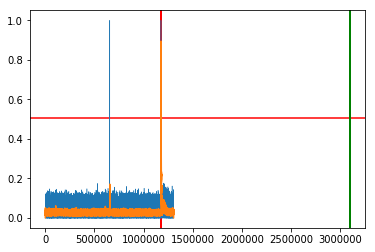

In [9]:

for i, bolid in enumerate(bolids.result):
    try:
        print(i,"==================================")
        print("snapshot:", bolid['url_file_js9'])
        bolids.result[i]['time_calib']=timeCalibration(bolid['url_file_raw'], bolid['station_name'])
    except Exception as e:
        print("for bolids.result:", e)
    

# Filtr nevyhovujících dat

Protože v některých datech nemusí být dobře detekovatelná GPS značka, je zde možné tyto soubory ručně vyřadit. A to tím, že odkomentujete druhý řádek následující buňky a do seznamu napíšete čísla vyhovujících RAW souborů. (Jsou k nalezení ve výstupu předchozí buňky)

In [10]:
time_offset = {}
selected = list(range(0, len(bolids.result)))     # vyber vsech dat

#selected.remove(0)
#selected.remove(1)
#selected.remove(4)
#selected = [0,1,2,3,6]

#selected = [3,4,5,6]     #Pokud chcete vybrat konkrétní data, 
                               #odkomentujte tento řádek a vložte do něj čísla požadovaných dat

# time_offset[0] = +0   ## Posun času na stanici.
                        # Timto posunete data pro určitou stanici (podle indexu souboru)
                        # o určitý počet časových značek (10s intervalů)
                        # Kladné číslo posune graf 'nahoru" 
#time_offset[3]=0.5
#time_offset[4]=0.5
#time_offset[1]=1
for i, bolid in enumerate(bolids.result):
    if bolid['time_calib']['quality'] < 50:
        selected.remove(i)
    if i in selected:
        print(i, bolid['time_calib']['quality'], 'sysT of gps:', bolid['time_calib']['cor_1st_GPS'], ',offset:', bolid['time_calib']['sys_correction'], bolid['filename'])

0 50 sysT of gps: 2017-09-20 15:32:31.544562 ,offset: 0:00:00 20170920153247610_VALMEZ-R1_met.fits
3 50 sysT of gps: 2017-09-20 15:32:33.533055 ,offset: 0:00:00 20170920153247454_DDMTREBIC-R3_met.fits
5 100 sysT of gps: 2017-09-20 15:32:30 ,offset: 0:00:01.622078 20170920153218631_SVAKOV-R12_met.fits
6 100 sysT of gps: 2017-09-20 15:32:40 ,offset: 0:00:00.669667 20170920153251991_CIIRC-R1_met.fits


# Zarovnané soubory

Toto je první buňka, jejíž výstup obsahuje časově zarovnané grafy. Pomocí proměnné ```gps_calib``` můžete nastavit, zdali Vaše zarovnání bude oproti absolutním GPS značkám (```gps_calib=True```) nebo oproti systémovému času stanic (```gps_calib=False```).

0 2017-09-20 15:32:31.544562
1 2017-09-20 15:32:33.533055
2 2017-09-20 15:32:28.822078
3 2017-09-20 15:32:33.869667
1505921548.822078 1505921561.622078


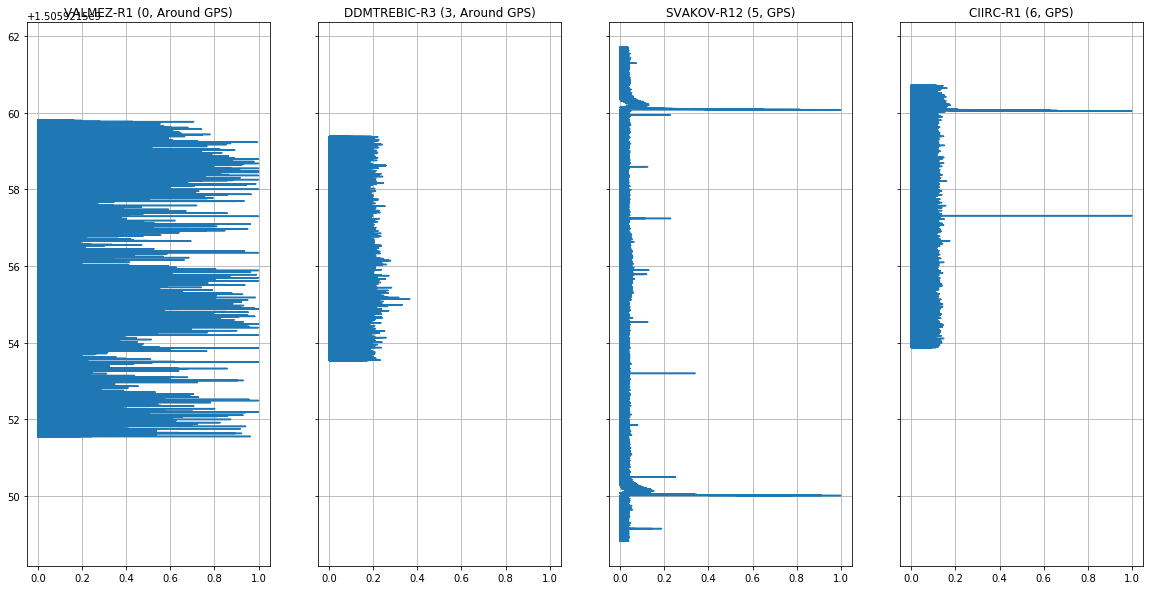

In [11]:
%matplotlib inline 
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

gps_calib = True
minimal_time = None
maximal_time = None

for i, ax in enumerate(axis):
    try:
        bolid = bolids.result[selected[i]]
        print (i, bolid['time_calib']['cor_file_beg'])
        hdulist = fits.open(bolid['url_file_raw'])
        met_data = np.abs(np.ravel(hdulist[0].data))

        T_offset = 10*time_offset.get(selected[i], 0)

        if gps_calib:
            ax.set_title(bolid['namesimple'] + " (%s, %s)"%(selected[i], bolid['time_calib']['method']))
            min_date = bolid['time_calib']['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            max_date = bolid['time_calib']['cor_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
        else:
            ax.set_title(bolid['namesimple'] + " (" + str(selected[i])+") SYS-T")
            min_date = bolid['time_calib']['sys_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            max_date = bolid['time_calib']['sys_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
        array = np.arange(min_date, max_date, (max_date-min_date)/(len(met_data)))

        if not minimal_time: minimal_time = min_date
        if not maximal_time: maximal_time = max_date
        if min_date < minimal_time: minimal_time = min_date
        if max_date > maximal_time: maximal_time = max_date

        ax.plot(met_data, array)
        ax.grid(True)
    except Exception as e:
        print(e)

fig.subplots_adjust(hspace=0)
print(minimal_time, maximal_time)

In [12]:
def waterfall(signal, sample_rate=None, bins = 4096 ):
    waterfall = recviewer.waterfallize(signal, bins)
    waterfall[np.isneginf(waterfall)] = np.nan
    wmin, wmax = np.nanmin(waterfall), np.nanmax(waterfall)
    return waterfall

{}


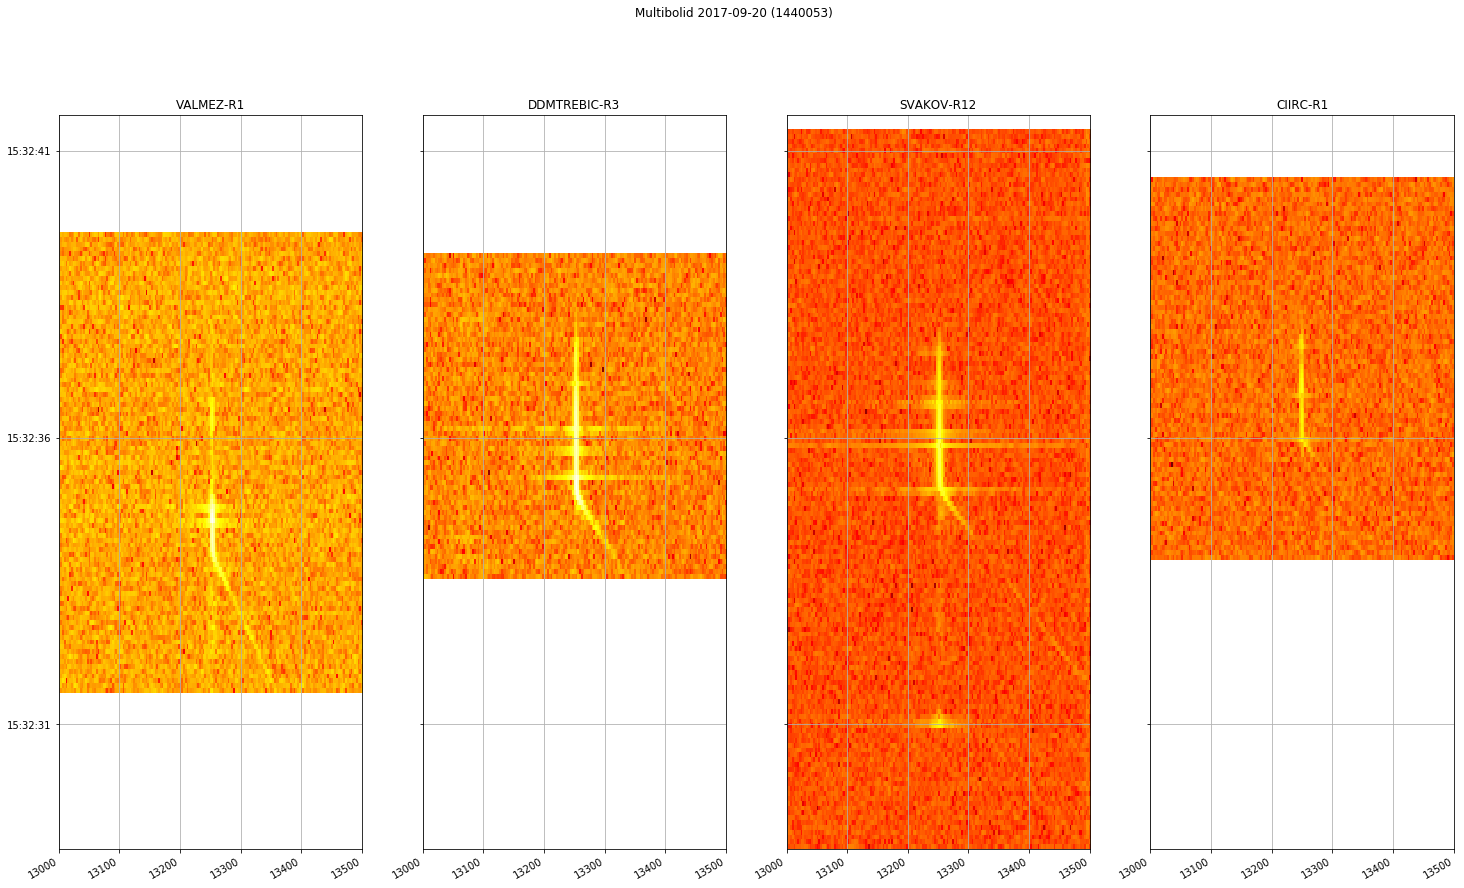

In [13]:
%matplotlib inline 
#%matplotlib notebook
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(25, 15))

print(time_offset)
fig.suptitle("Multibolid %s (%s)" %(datetime.datetime.utcfromtimestamp(minimal_time).date(), multibolid_id))
fig.subplots_adjust(hspace=0)
plt.set_cmap('hot')
for i, ax in enumerate(axis):
    bolid = bolids.result[selected[i]]
    hdu = fits.open(bolid['url_file_raw'])[0]
    flat_data = np.ravel(hdu.data)
    
    T_offset = datetime.timedelta(seconds = 10*time_offset.get(selected[i], 0))
    #print(i, selected[i], bolid['time_calib']['cor_file_beg'], bolid['time_calib']['cor_file_beg']+T_offset, T_offset)
    d1 = bolid['time_calib']['cor_file_beg']+T_offset
    fds1 = dates.date2num(d1) # converted
    d2 = d1 + datetime.timedelta(seconds=hdu.header['NAXIS2']/49000.0/2)
    fds2 = dates.date2num(d2)
    
    arr = waterfall(flat_data[0::2] + 1j * flat_data[1::2], 49000, bins = 4096*4)
    ax.imshow(arr,  interpolation='none', aspect='auto',  extent=[-24000, 24000, fds2, fds1])
    ax.grid(True)
    
    ax.set_xlim(13000,13500)
    ax.yaxis_date()
    date_format = md.DateFormatter('%H:%M:%S')
    ax.yaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    ax.set_ylim( datetime.datetime.utcfromtimestamp(minimal_time), datetime.datetime.utcfromtimestamp(maximal_time))
    
    #offset = abs(bolid['time_calib']['sys_correction']).microseconds/1000000 + abs(bolid['time_calib']['cor_error']).seconds
    #if bolid['time_calib']['sys_correction'] < datetime.timedelta(seconds=0): offset = -offset
    #ax.set_title(bolid['namesimple']+ " err:"+str(offset))
    ax.set_title(bolid['namesimple'])
plt.savefig('output.png', dpi=300)



In [5]:
export = 'multibolid_%s_%s.ipynb' %(datetime.datetime.utcfromtimestamp(minimal_time).date(), multibolid_id)
print(export)
#%notebook $export

NameError: name 'minimal_time' is not defined

# Tweet
Tato část odešle multibolid porovnání na twitter účet bolidozoru. https://twitter.com/bolidozor

V počítači je potřeba mít vytvořený konfigurační soubor s kódy pro přihlášení. Takový soubor musí vypadat takto

```
[twitter]
CONSUMER_KEY = consumer_key
CONSUMER_SECRET = consumer_secret
ACCESS_TOKEN_KEY = access_token_key
ACCESS_TOKEN_SECRET = access_token_secret
```

Pokud při uploadování se nenahraje obrázek kvůli TimeOutu, zkuste zmenšit DPI grafu.

In [ ]:
from TwitterAPI import TwitterAPI
import base64
import configparser

parser = configparser.ConfigParser()
parser.read('/home/roman/bolidozor_access.ini')
CONSUMER_KEY = parser['twitter']['CONSUMER_KEY']
CONSUMER_SECRET = parser['twitter']['CONSUMER_SECRET']
ACCESS_TOKEN_KEY = parser['twitter']['ACCESS_TOKEN_KEY']
ACCESS_TOKEN_SECRET =parser['twitter']['ACCESS_TOKEN_SECRET']

file = open('output.png', 'rb')
data = base64.b64encode(file.read())

api = TwitterAPI(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN_KEY, ACCESS_TOKEN_SECRET, auth_type='oAuth1')
media = api.request('media/upload', None, {'media_data':data})
print(media.status_code, media.text)
m_id = json.loads(media.text)['media_id']
print(m_id)
#print(media.text)
status_text='''
Multibolid-event on %s (id:%s)
More details at http://rtbolidozor.astro.cz/multibolid/event/%s/

This tweet was uploaded from Multibolid-analyser
''' %(datetime.datetime.utcfromtimestamp(minimal_time).date(), multibolid_id, multibolid_id)

r = api.request('statuses/update', {'status':status_text, 'media_ids':m_id})
print(r.status_code, r.text)


# Extract head-echo


len 4
0 0 http://space.astro.cz/bolidozor/valmez/VALMEZ-R1/meteors/2017/09/20/15/20170920153247610_VALMEZ-R1_raws.fits


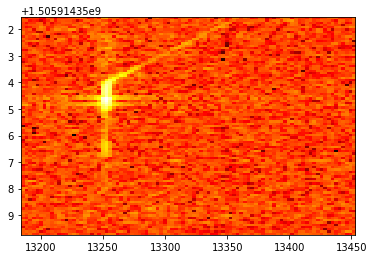

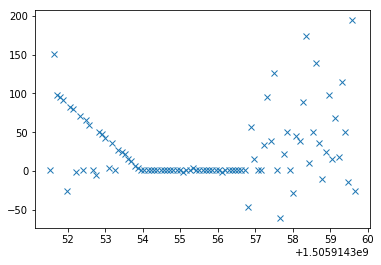

1 3 http://space.astro.cz/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/09/20/15/20170920153247454_DDMTREBIC-R3_raws.fits


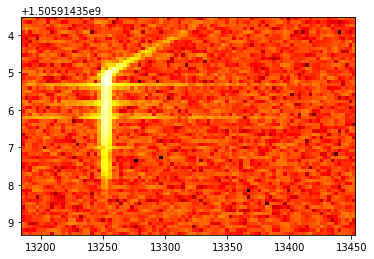

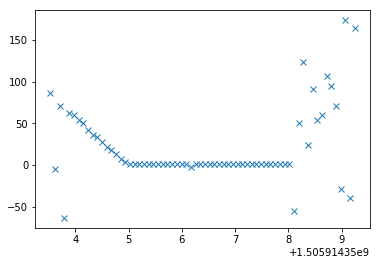

2 5 http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/20/15/20170920153218631_SVAKOV-R12_raws.fits


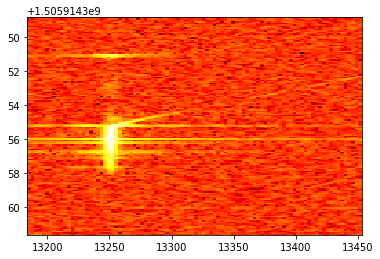

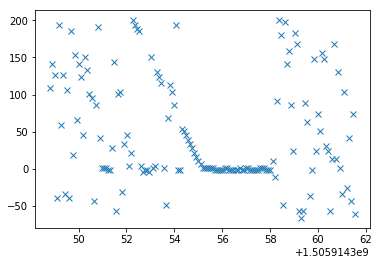

3 6 http://space.astro.cz/bolidozor/CIIRC/CIIRC-R1/meteors/2017/09/20/15/20170920153251991_CIIRC-R1_raws.fits


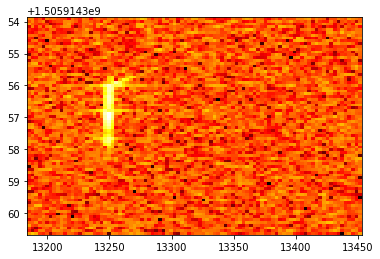

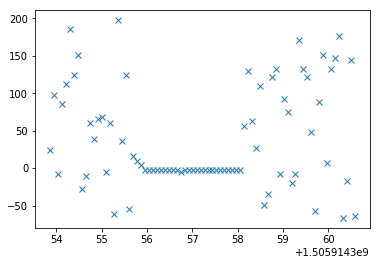

In [23]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='full')
    return y_smooth


%matplotlib inline 
#%matplotlib notebook
print('len', len(selected))

#print(time_offset)
#fig.suptitle("Multibolid %s (%s)" %(datetime.datetime.utcfromtimestamp(minimal_time).date(), multibolid_id))
#fig.subplots_adjust(hspace=0)
#plt.set_cmap('hot')

'''
head_lines = {
    #0:[(4,13350),(25,13250)]
    0:[[2,27],[13350,13250]],
    3:[[0,16],[13335,13250]],
    4:[[4,24],[13360,13250]],
    6:[[41,73],[13450,13250]]
}
'''

f = open("meteor_%s_%s_raw.obs"%(multibolid_id, datetime.datetime.utcfromtimestamp(minimal_time).date()), 'w')
f.write('#F %s\n' %datetime.datetime.utcfromtimestamp(minimal_time).date())
for i, meteor in enumerate(selected):
    f.write('\n')
    %matplotlib inline
    bolid = bolids.result[meteor]
    print(i, meteor, bolid['url_file_raw'])
    
    hdu = fits.open(bolid['url_file_raw'])[0]
    flat_data = np.ravel(hdu.data)
    
    bins = 4096*2
    arr = waterfall(flat_data[0::2] + 1j * flat_data[1::2], 49000, bins = bins*2)[:,bins:]
    min_crop = 4500
    max_crop = 3600
    file_length = samp2time(hdu.header['NAXIS2']*2)    
    step_time = file_length/(arr.shape[0])
        
    step_freq = 24000/bins
    min_freq = min_crop*step_freq
    max_freq = 24000 - max_crop*step_freq

    selection = arr[:,+min_crop:-max_crop]
    
    plt.imshow(selection, aspect='auto', extent=[min_freq, max_freq,
                                                 bolid['time_calib']['cor_file_end'].timestamp(),
                                                 bolid['time_calib']['cor_file_beg'].timestamp()])

    plt.show()
    
    peak = np.empty([0,2])
    for i, row in enumerate(selection):
        max_i = np.argmax(row)
        max_v = row[max_i]
        peak = np.concatenate((peak, [[bolid['time_calib']['cor_file_beg'].timestamp()+i*step_time, -13250+(min_crop+max_i)*step_freq]]))
        f.write("%i\t%f\t%f\n" %(meteor,
                                 #bolid['time_calib']['cor_file_beg']+datetime.timedelta(seconds=i*step_time),
                                 bolid['time_calib']['cor_file_beg'].timestamp()+i*step_time,
                                 -13250+(min_crop+max_i)*step_freq
                                )
                )
        #plt.plot(row)
        #plt.show()
        #plt.plot(row)
    #plt.show()
    
    #plt.plot(peak[:,0], peak[:,1])
    plt.plot(peak[:,0],peak[:,1], 'x')
    
    '''  Tato část slouží k hledani bodu headecha podle primek 'head_lines'
    head = np.empty([0,2])
    if meteor in head_lines:
        plt.plot(head_lines[meteor][0],head_lines[meteor][1])
        vector = (1, (head_lines[meteor][1][1]-head_lines[meteor][1][0])/(head_lines[meteor][0][1]-head_lines[meteor][0][0]))
        print(vector)
        for p in peak:
            if head_lines[meteor][0][0] <= p[0] <= head_lines[meteor][0][1]:
                #print(p)
                pos = (p[0]+1)*vector[0]
                d = (head_lines[meteor][1][0]+(pos+1)*vector[1]) - p[1]
                #print(pos, d, p[1])
                if abs(d) < 50:
                    head = np.concatenate((head, [[p[0], p[1]]]))
                
                #d = np.linalg.norm(np.cross(head_lines[meteor][0][1]-head_lines[meteor][0][0], head_lines[meteor][1][1]-head_lines[meteor][1][0]))/np.linalg.norm(p[1])
                #print(d)
        plt.plot(head[:,1], '*')
    '''
        
    plt.show()
    #print(peak)
f.close()

# Výběr head-echa

Nyní je potřeba otevřít soubor ```meteor_[id]_[date]_raw.obs``` a v něm odstanit (nebo zakomentovat '#') řádky, které neodpovídají head-echu. Následně je potřeba soubor uložit s názvem ```meteor_[id]_[date]_clean.obs```. Následující buňka vykreslí vybraná data.

4
4 {'time': [1505914354.392744, 1505914355.003, 1505914355.177359, 1505914355.438898, 1505914355.700436, 1505914355.787616, 1505914355.874795, 1505914355.961975], 'value': [124.023438, 68.359375, 59.570312, 36.132812, 15.625, 9.765625, 3.90625, -1.953125]}
3
3 {'time': [1505914353.533055, 1505914353.708813, 1505914353.88457, 1505914353.972449, 1505914354.060328, 1505914354.148206, 1505914354.236085, 1505914354.323964, 1505914354.411843, 1505914354.499722, 1505914354.5876, 1505914354.675479, 1505914354.763358, 1505914354.851237, 1505914354.939116, 1505914355.026994], 'value': [85.9375, 71.289062, 62.5, 59.570312, 53.710938, 50.78125, 41.992188, 36.132812, 33.203125, 27.34375, 21.484375, 18.554688, 12.695312, 6.835938, 3.90625, 0.976562]}
6
6 {'time': [1505914352.25832, 1505914352.344226, 1505914352.430132, 1505914352.516038, 1505914353.031474, 1505914353.289192, 1505914353.375098, 1505914353.461004, 1505914353.97644, 1505914354.320065, 1505914354.405971, 1505914354.491877, 1505914354.5

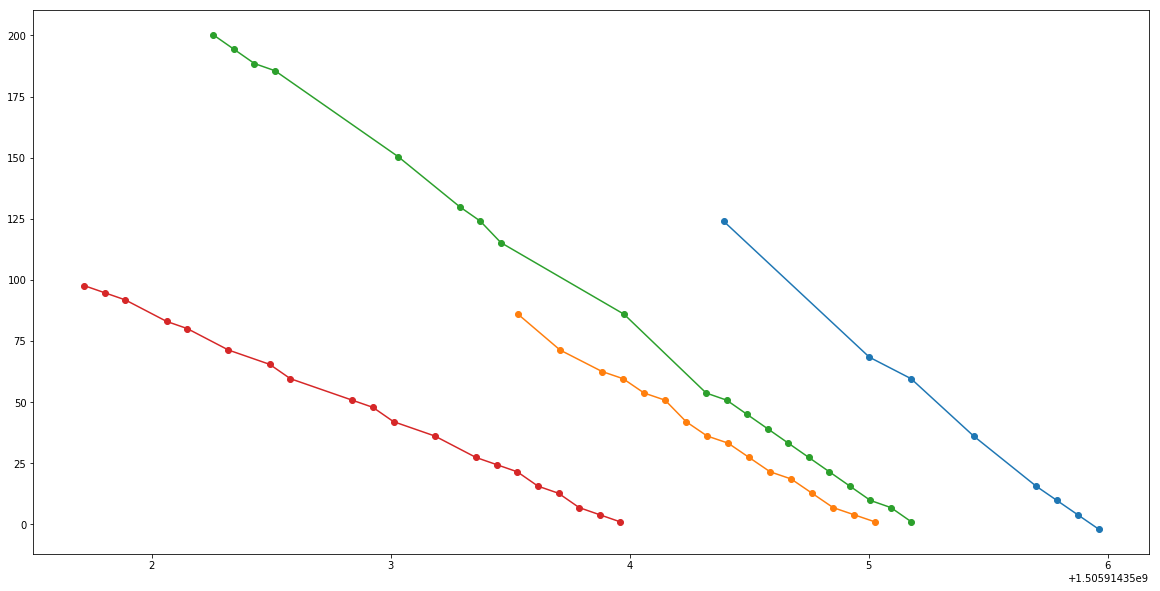

In [24]:
%matplotlib inline
#%matplotlib interactive
#import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,10)
f = open("meteor_%s_%s_clean.obs"%(multibolid_id, datetime.datetime.utcfromtimestamp(minimal_time).date()), 'r')
met_p = {}
for line in f.readlines():
    if ('#' not in line) and ('\t' in line):
        split = line.split('\t')
        if not split[0] in met_p: met_p[split[0]]={'time':[], 'value':[]}
        met_p[split[0]]['time'].append(float(split[1]))
        met_p[split[0]]['value'].append(float(split[2]))
#print(met_p)

for station in met_p:
    print(station)
    print(station, met_p[station])
    plt.plot(met_p[station]['time'],met_p[station]['value'], 'o-')
plt.show()